In [1]:
!pip install xgboost

# setting logging to print only error messages from Sklearnex
import logging
logging.basicConfig()
logging.getLogger("SKLEARNEX").setLevel(logging.ERROR)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns
from datetime import datetime

from statsmodels.tsa.stattools import adfuller,kpss
from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn.metrics import mean_squared_error,mean_absolute_error
import math
import xgboost as xgb
import warnings
warnings.filterwarnings("ignore")

sns.set_theme(palette="Set2")
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')


def get_mda(y, yhat):
    """Mean Directional Accuracy, as per:
    https://www.wikiwand.com/en/Mean_Directional_Accuracy
    """
    a = np.sign(np.diff(y))
    b = np.sign(np.diff(yhat))
    return np.sum(a == b)/a.shape[0]

In [10]:
df=pd.read_csv("MICROSOFT BP DATA.csv")

In [11]:
df.head()

,Date,Open,High,Low,Close,Volume,Day of the week,Change,NASDAQ
0,01-04-2014,41.150002,41.590000,41.070000,41.419998,32605000.0,3.0,-0.070000,3658.399902
1,02-04-2014,41.439999,41.660000,41.169998,41.349998,28666700.0,4.0,-0.340000,3665.989990
2,03-04-2014,41.290001,41.290001,40.709999,41.009998,30139600.0,5.0,-1.139999,3637.580078
3,04-04-2014,41.250000,41.389999,39.639999,39.869999,51409600.0,6.0,-0.070000,3539.379883
4,07-04-2014,39.959999,40.270000,39.740002,39.799999,37559600.0,2.0,0.020001,3507.750000


In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2267 entries, 0 to 2266
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Date             2205 non-null   object 
 1   Open             2205 non-null   float64
 2   High             2205 non-null   float64
 3   Low              2205 non-null   float64
 4   Close            2205 non-null   float64
 5   Volume           2205 non-null   float64
 6   Day of the week  2205 non-null   float64
 7   Change           2205 non-null   float64
 8   NASDAQ           2205 non-null   float64
dtypes: float64(8), object(1)
memory usage: 159.5+ KB


## Convert the "time" column to the datetime type

In [13]:
df["Date"] = pd.to_datetime(df["Date"])

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2267 entries, 0 to 2266
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   Date             2205 non-null   datetime64[ns]
 1   Open             2205 non-null   float64       
 2   High             2205 non-null   float64       
 3   Low              2205 non-null   float64       
 4   Close            2205 non-null   float64       
 5   Volume           2205 non-null   float64       
 6   Day of the week  2205 non-null   float64       
 7   Change           2205 non-null   float64       
 8   NASDAQ           2205 non-null   float64       
dtypes: datetime64[ns](1), float64(8)
memory usage: 159.5 KB


In [15]:
df.set_index('Date',inplace=True)

In [16]:
df.head()

,Open,High,Low,Close,Volume,Day of the week,Change,NASDAQ
Date,,,,,,,,
2014-01-04,41.150002,41.590000,41.070000,41.419998,32605000.0,3.0,-0.070000,3658.399902
2014-02-04,41.439999,41.660000,41.169998,41.349998,28666700.0,4.0,-0.340000,3665.989990
2014-03-04,41.290001,41.290001,40.709999,41.009998,30139600.0,5.0,-1.139999,3637.580078
2014-04-04,41.250000,41.389999,39.639999,39.869999,51409600.0,6.0,-0.070000,3539.379883
2014-07-04,39.959999,40.270000,39.740002,39.799999,37559600.0,2.0,0.020001,3507.750000


In [17]:
df = df.iloc[:-62, :]

In [18]:
df.tail()

,Open,High,Low,Close,Volume,Day of the week,Change,NASDAQ
Date,,,,,,,,
2022-12-23,236.110001,238.869995,233.940002,238.729996,21207000.0,6.0,-1.769989,10985.45020
2022-12-27,238.699997,238.929993,235.830002,236.960007,16688600.0,3.0,-2.430008,10822.50977
2022-12-28,236.889999,239.720001,234.169998,234.529999,17457100.0,4.0,6.479996,10679.33984
2022-12-29,235.649994,241.919998,235.649994,241.009995,19770700.0,5.0,-1.189988,10951.04981
2022-12-30,238.210007,239.960007,236.660004,239.820007,21938500.0,6.0,-0.240005,10939.75977


# Missing entries


In [19]:
min(df.index)

Timestamp('2014-01-04 00:00:00')

In [20]:
max(df.index)

Timestamp('2022-12-30 00:00:00')

In [21]:
all_datetimes = pd.date_range(min(df.index), max(df.index), freq="D")
all_datetimes

DatetimeIndex(['2014-01-04', '2014-01-05', '2014-01-06', '2014-01-07',
               '2014-01-08', '2014-01-09', '2014-01-10', '2014-01-11',
               '2014-01-12', '2014-01-13',
               ...
               '2022-12-21', '2022-12-22', '2022-12-23', '2022-12-24',
               '2022-12-25', '2022-12-26', '2022-12-27', '2022-12-28',
               '2022-12-29', '2022-12-30'],
              dtype='datetime64[ns]', length=3283, freq='D')

In [22]:
all_datetimes.shape

(3283,)

# Supplying missing values


## Insert missing datetimes

In [23]:
all_datetimes_df = pd.DataFrame(index=all_datetimes)
all_datetimes_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3283 entries, 2014-01-04 to 2022-12-30
Freq: D
Empty DataFrame

In [24]:
df = pd.merge(all_datetimes_df, df, how="left", left_index=True, right_index=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3283 entries, 2014-01-04 to 2022-12-30
Freq: D
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Open             2205 non-null   float64
 1   High             2205 non-null   float64
 2   Low              2205 non-null   float64
 3   Close            2205 non-null   float64
 4   Volume           2205 non-null   float64
 5   Day of the week  2205 non-null   float64
 6   Change           2205 non-null   float64
 7   NASDAQ           2205 non-null   float64
dtypes: float64(8)
memory usage: 359.9 KB


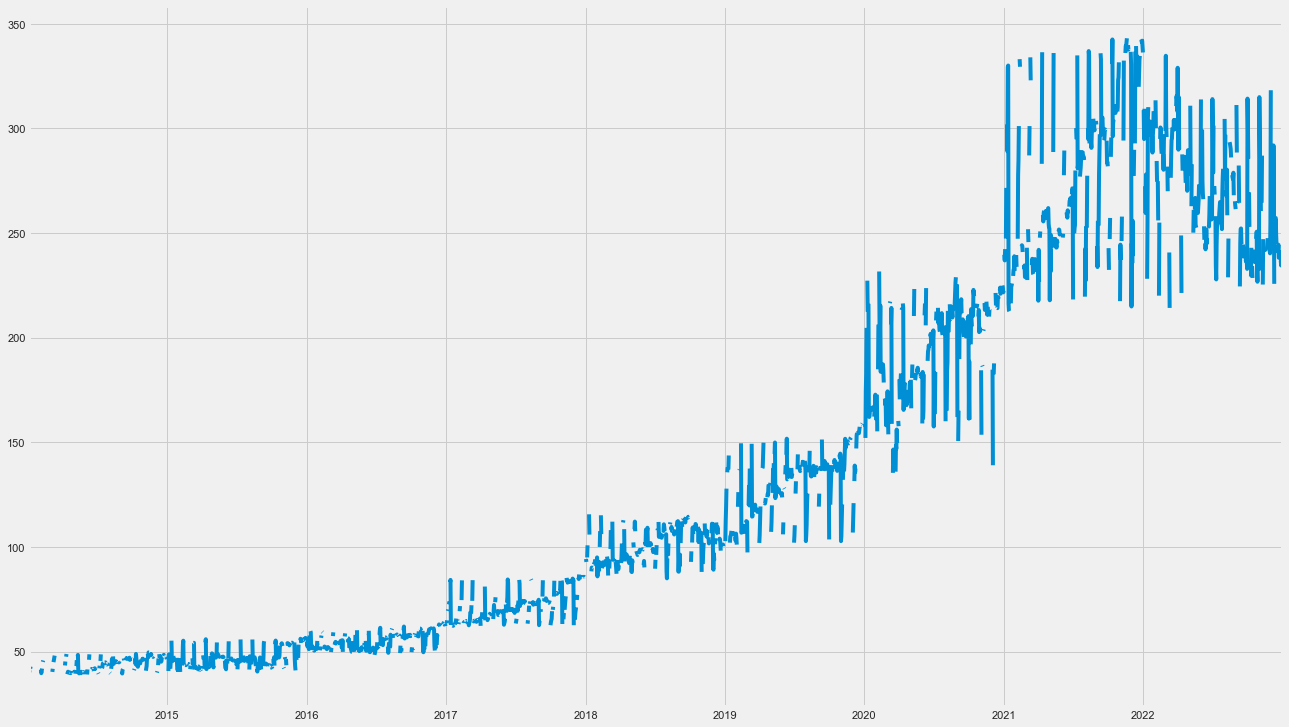

In [25]:
plot = df['Close'].plot(figsize=(20, 12))

# forward fill

In [26]:
df["ffilled"] = df["Close"].ffill()
df["NASDAQ"]=df["NASDAQ"].ffill()
df.head(12)

,Open,High,Low,Close,Volume,Day of the week,Change,NASDAQ,ffilled
2014-01-04,41.150002,41.590000,41.070000,41.419998,32605000.0,3.0,-0.070000,3658.399902,41.419998
2014-01-05,40.240002,40.360001,39.950001,40.000000,28787400.0,5.0,-0.310001,3594.360107,40.000000
2014-01-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3594.360107,40.000000
2014-01-07,41.860001,42.150002,41.689999,41.869999,26917000.0,3.0,0.030003,3894.330078,41.869999
2014-01-08,43.209999,43.250000,42.599998,42.860001,31170300.0,6.0,0.509998,3879.669922,42.860001
2014-01-09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3879.669922,42.860001
2014-01-10,46.270000,46.529999,45.849998,45.900002,38088400.0,4.0,-0.140004,3984.739990,45.900002
2014-01-11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3984.739990,45.900002
2014-01-12,47.880001,48.779999,47.709999,48.619999,31191600.0,2.0,-0.160000,4287.810059,48.619999
2014-01-13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4287.810059,48.619999


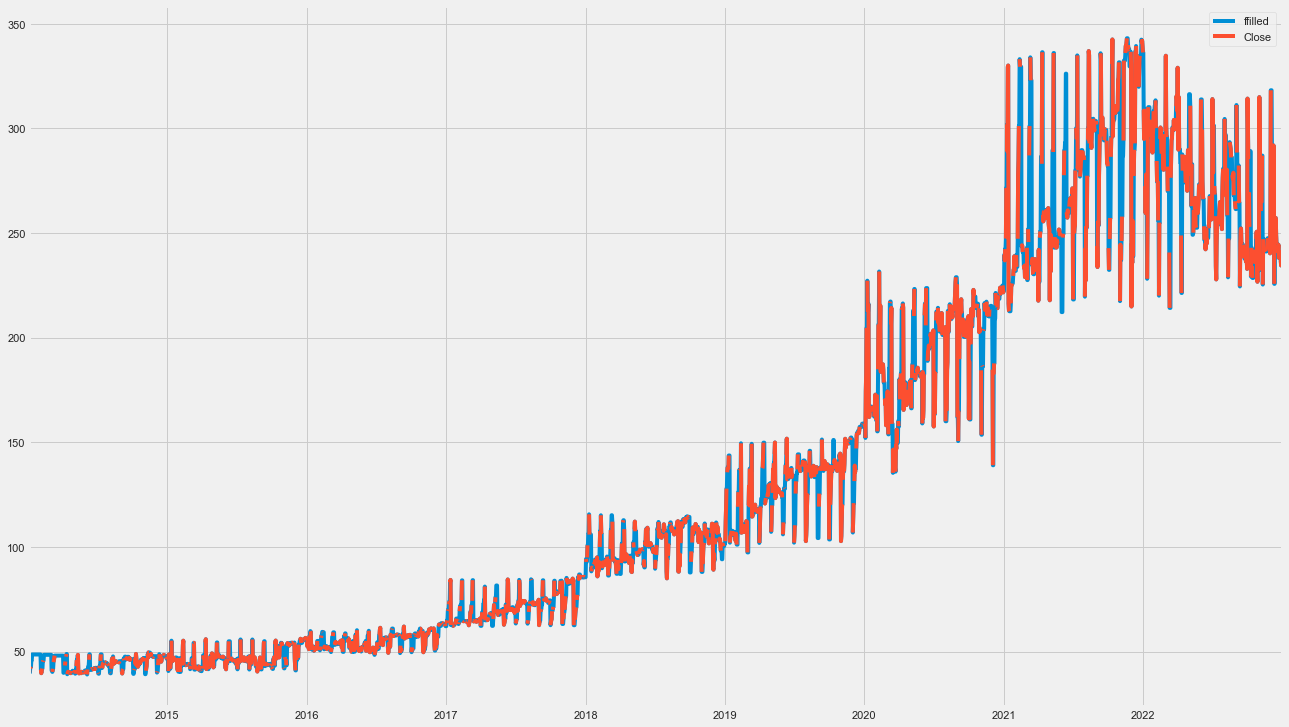

In [27]:
df = df[["ffilled", "Close","NASDAQ","Change"]]
plot = df[["ffilled", "Close"]].plot(figsize=(20, 12))

In [28]:
df.ffilled

2014-01-04     41.419998
2014-01-05     40.000000
2014-01-06     40.000000
2014-01-07     41.869999
2014-01-08     42.860001
                 ...    
2022-12-26    238.729996
2022-12-27    236.960007
2022-12-28    234.529999
2022-12-29    241.009995
2022-12-30    239.820007
Freq: D, Name: ffilled, Length: 3283, dtype: float64

In [29]:
df.rename(columns={"ffilled": "close"}, inplace=True)
df

,close,Close,NASDAQ,Change
2014-01-04,41.419998,41.419998,3658.399902,-0.070000
2014-01-05,40.000000,40.000000,3594.360107,-0.310001
2014-01-06,40.000000,NaN,3594.360107,NaN
2014-01-07,41.869999,41.869999,3894.330078,0.030003
2014-01-08,42.860001,42.860001,3879.669922,0.509998
...,...,...,...,...
2022-12-26,238.729996,NaN,10985.450200,NaN
2022-12-27,236.960007,236.960007,10822.509770,-2.430008
2022-12-28,234.529999,234.529999,10679.339840,6.479996
2022-12-29,241.009995,241.009995,10951.049810,-1.189988


In [30]:
df.drop(["Close"],axis=1,inplace=True)

In [31]:
df

,close,NASDAQ,Change
2014-01-04,41.419998,3658.399902,-0.070000
2014-01-05,40.000000,3594.360107,-0.310001
2014-01-06,40.000000,3594.360107,NaN
2014-01-07,41.869999,3894.330078,0.030003
2014-01-08,42.860001,3879.669922,0.509998
...,...,...,...
2022-12-26,238.729996,10985.450200,NaN
2022-12-27,236.960007,10822.509770,-2.430008
2022-12-28,234.529999,10679.339840,6.479996
2022-12-29,241.009995,10951.049810,-1.189988


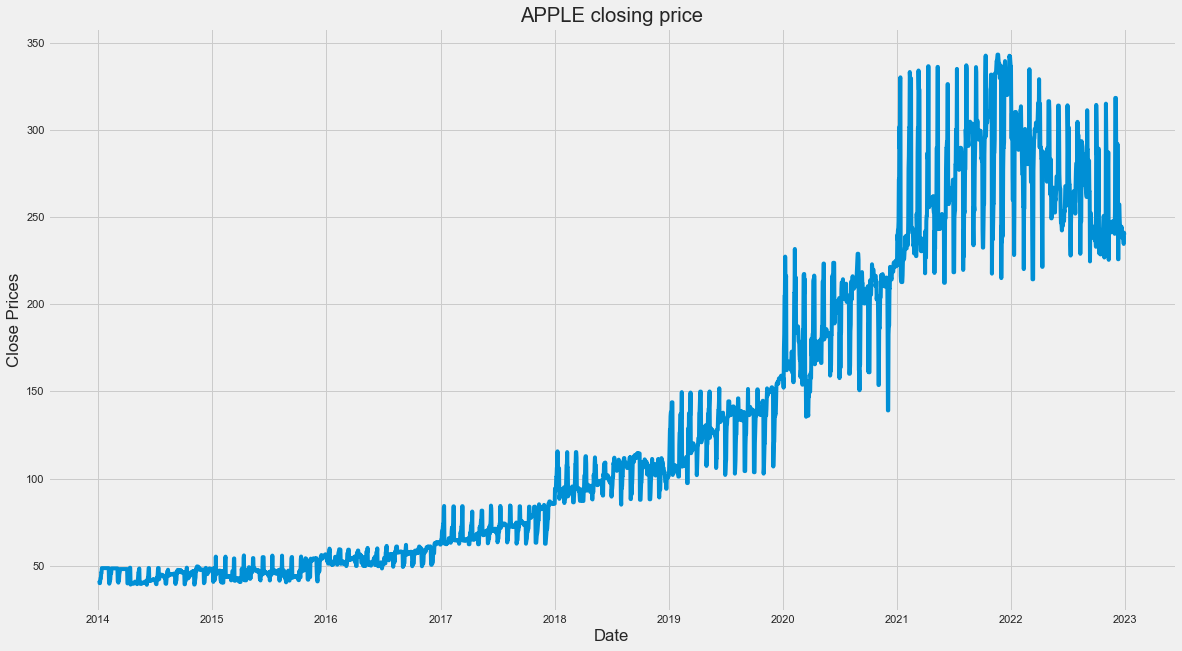

In [32]:
#plot close price
plt.figure(figsize=(18,10))
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('Close Prices')
plt.plot(df['close'])
plt.title('APPLE closing price')
plt.show()

# checking stationarity of the data


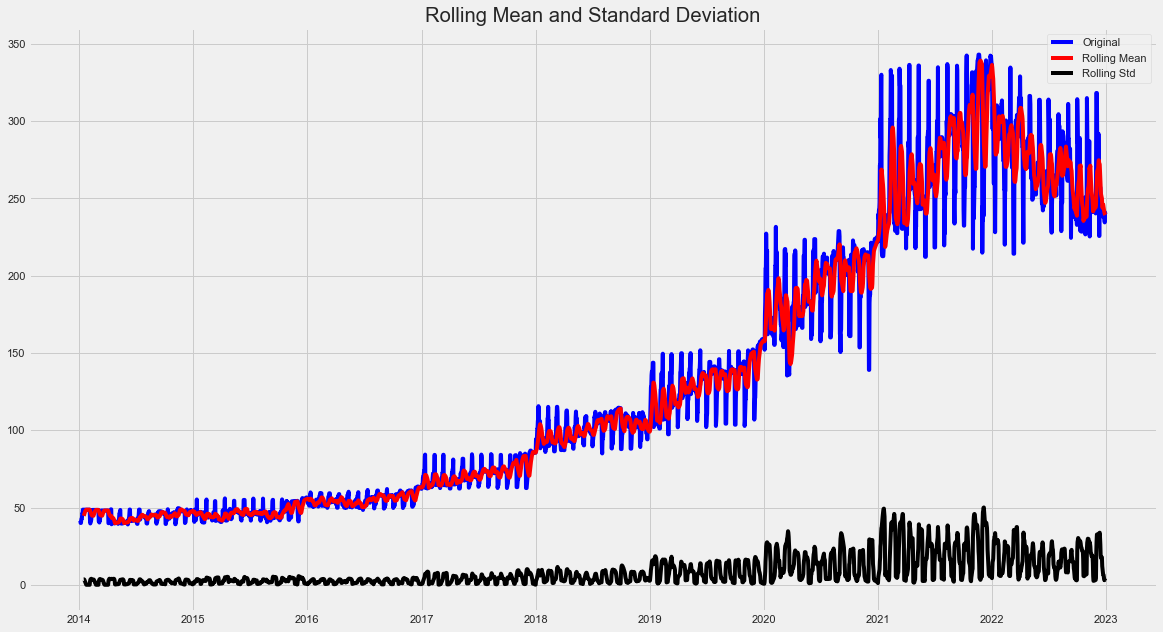

Results of dickey fuller test
Test Statistics                   0.438566
p-value                           0.982881
No. of lags used                 29.000000
Number of observations used    3253.000000
critical value (1%)              -3.432362
critical value (5%)              -2.862429
critical value (10%)             -2.567243
dtype: float64


In [33]:
#Test for staionarity
def test_stationarity(timeseries):
    #Determing rolling statistics
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()
    
    plt.figure(figsize=(18, 10))

    #Plot rolling statistics:
    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.show(block=False)
    print("Results of dickey fuller test")
    adft = adfuller(timeseries,autolag='AIC')
    # output for dft will give us without defining what the values are.
    #hence we manually write what values does it explains using a for loop
    output = pd.Series(adft[0:4],index=['Test Statistics','p-value','No. of lags used','Number of observations used'])
    for key,values in adft[4].items():
        output['critical value (%s)'%key] =  values
    print(output)
test_stationarity(df.close)

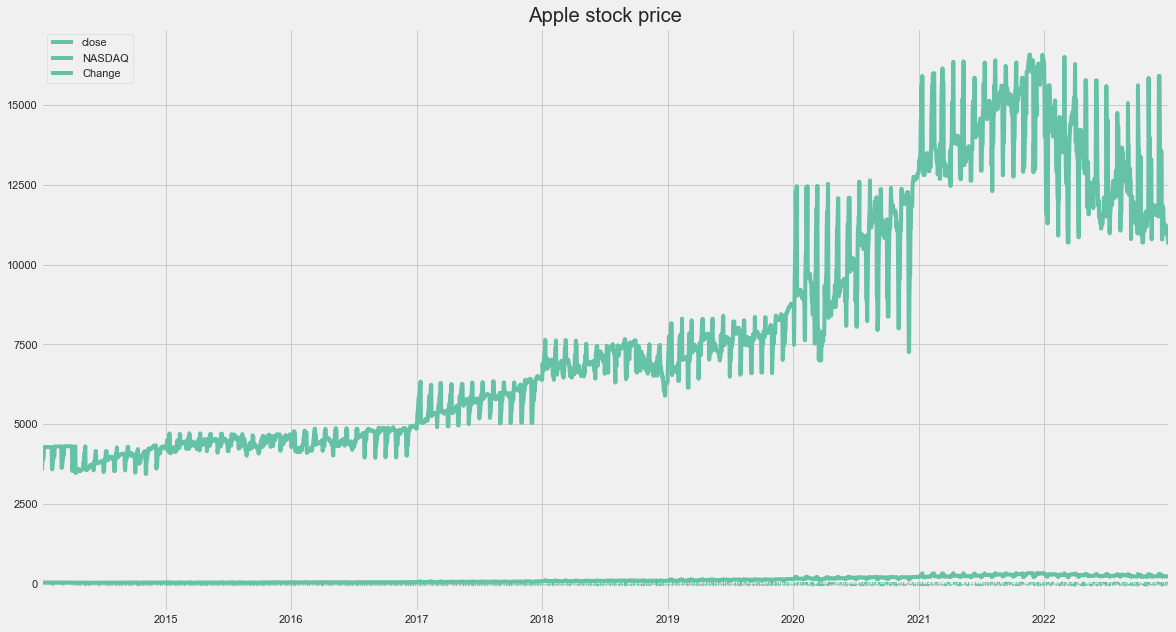

In [34]:
df.plot(style='-',
        figsize=(18, 10),
        color=color_pal[0],
        title='Apple stock price')
plt.show()

## Train / Test Split¶


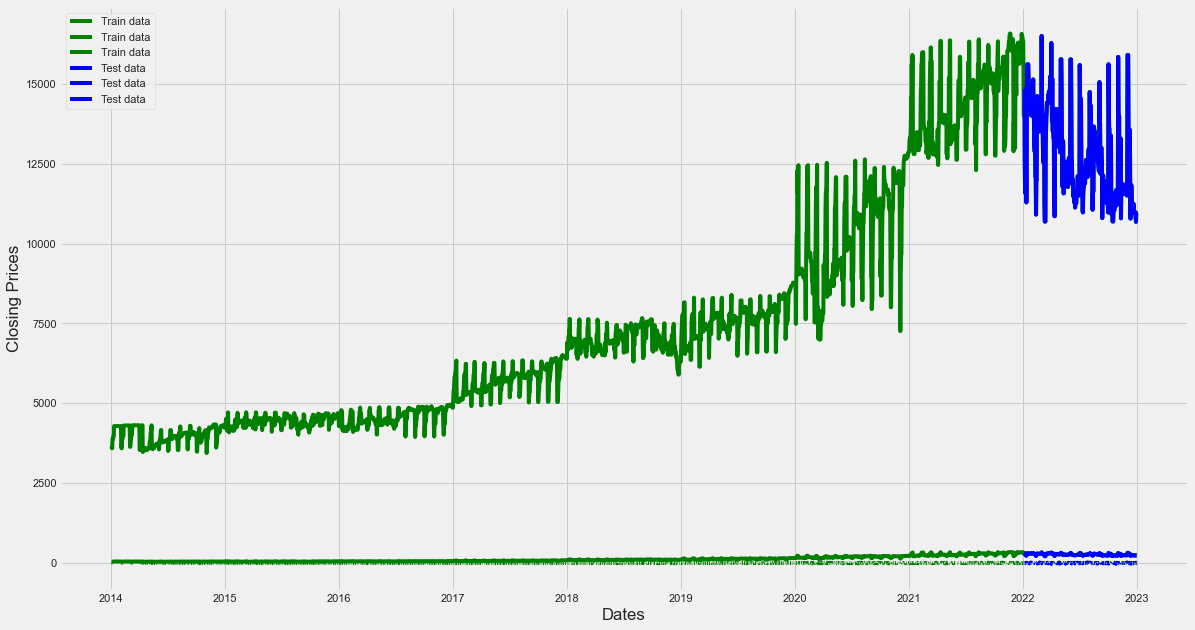

In [35]:
train_data = df.loc[df.index < '01-04-2022']
test_data = df.loc[df.index >= '01-04-2022']
plt.figure(figsize=(18,10))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(df, 'green', label='Train data')
plt.plot(test_data, 'blue', label='Test data')
plt.legend()

In [36]:
train_data.shape

(2922, 3)

In [37]:
test_data.tail()

,close,NASDAQ,Change
2022-12-26,238.729996,10985.45020,NaN
2022-12-27,236.960007,10822.50977,-2.430008
2022-12-28,234.529999,10679.33984,6.479996
2022-12-29,241.009995,10951.04981,-1.189988
2022-12-30,239.820007,10939.75977,-0.240005


In [38]:
test_data.shape

(361, 3)

In [39]:
def create_features(df):
    """
    Create time series features based on time series index.
    """
    df = df.copy()
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week
    return df

df = create_features(df)

# Visualize our Feature / Target Relationship¶


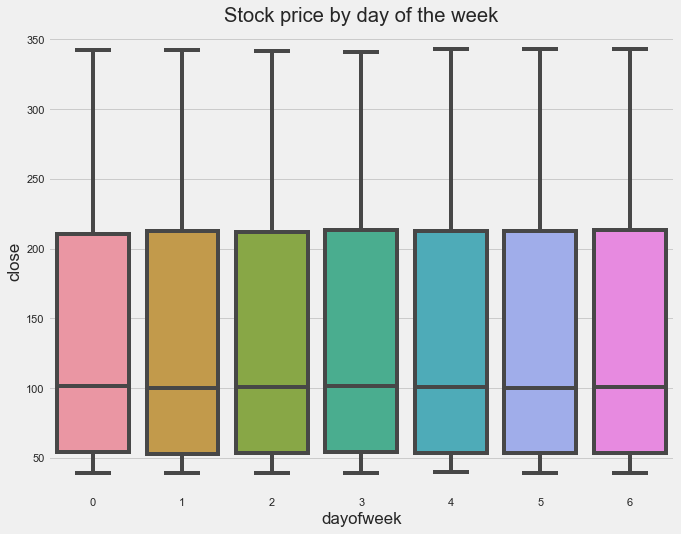

In [40]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df, x='dayofweek', y='close')
ax.set_title('Stock price by day of the week')
plt.show()

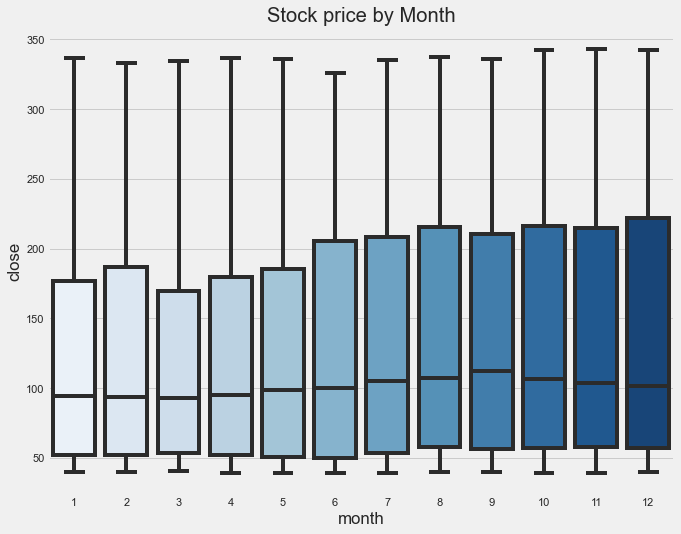

In [41]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df, x='month', y='close', palette='Blues')
ax.set_title('Stock price by Month')
plt.show()

# Create our Model¶


In [42]:
train = create_features(train_data)
test = create_features(test_data)

FEATURES = ['dayofyear', 'dayofweek', 'quarter', 'month', 'year','NASDAQ','Change']
TARGET = 'close'

X_train = train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]

In [43]:
reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
                       n_estimators=1000,
                       early_stopping_rounds=50,
                       objective='reg:linear',
                       max_depth=3,
                       learning_rate=0.01)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=100)

[0]	validation_0-rmse:137.85493	validation_1-rmse:267.38744
[100]	validation_0-rmse:51.17247	validation_1-rmse:119.56979
[200]	validation_0-rmse:19.33813	validation_1-rmse:64.96572
[300]	validation_0-rmse:8.05009	validation_1-rmse:45.36291
[400]	validation_0-rmse:4.53516	validation_1-rmse:35.00450
[500]	validation_0-rmse:3.66764	validation_1-rmse:26.04568
[600]	validation_0-rmse:3.44813	validation_1-rmse:23.02480
[700]	validation_0-rmse:3.35809	validation_1-rmse:19.84409
[800]	validation_0-rmse:3.31619	validation_1-rmse:17.33143
[900]	validation_0-rmse:3.26868	validation_1-rmse:16.20355
[999]	validation_0-rmse:3.22415	validation_1-rmse:15.46714


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, objective='reg:linear', ...)

# Feature Importance¶


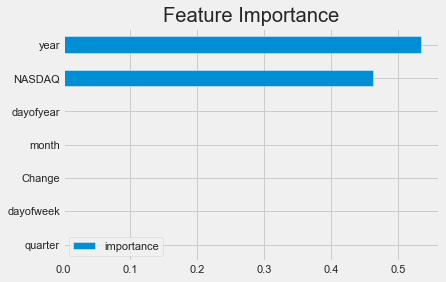

In [44]:
fi = pd.DataFrame(data=reg.feature_importances_,
             index=reg.feature_names_in_,
             columns=['importance'])
fi.sort_values('importance').plot(kind='barh', title='Feature Importance')
plt.show()

# Forecast on Test


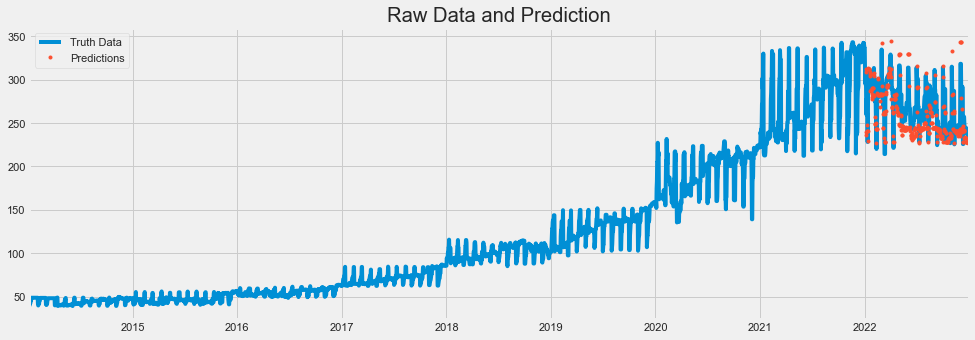

In [45]:
test['prediction'] = reg.predict(X_test)
df = df.merge(test[['prediction']], how='left', left_index=True, right_index=True)
ax = df[['close']].plot(figsize=(15, 5))
df['prediction'].plot(ax=ax, style='.')
plt.legend(['Truth Data', 'Predictions'])
ax.set_title('Raw Data and Prediction')
plt.show()

In [46]:
df['prediction'].tail(365)

2021-12-31           NaN
2022-01-01           NaN
2022-01-02           NaN
2022-01-03           NaN
2022-01-04    311.720001
                 ...    
2022-12-26    228.463898
2022-12-27    228.582413
2022-12-28    227.554855
2022-12-29    227.931885
2022-12-30    227.855927
Freq: D, Name: prediction, Length: 365, dtype: float32

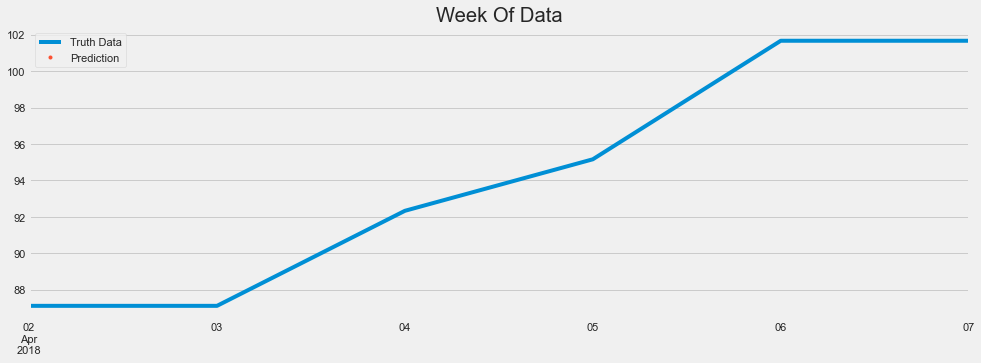

In [47]:
ax = df.loc[(df.index > '04-01-2018') & (df.index < '04-08-2018')]['close'] \
    .plot(figsize=(15, 5), title='Week Of Data')
df.loc[(df.index > '04-01-2018') & (df.index < '04-08-2018')]['prediction'] \
    .plot(style='.')
plt.legend(['Truth Data','Prediction'])
plt.show()

# Score (RMSE)

In [48]:
score = np.sqrt(mean_squared_error(test['close'], test['prediction']))
print(f'RMSE Score on Test set: {score:0.2f}')

RMSE Score on Test set: 15.47


# Calculate error

In [49]:
test['error'] = np.abs(test[TARGET] - test['prediction'])
test['date'] = test.index.date
test.groupby(['date'])['error'].mean().sort_values(ascending=False).head(10)

date
2022-01-06    32.189056
2022-06-05    30.648163
2022-01-08    30.614990
2022-07-30    30.597168
2022-07-31    30.597168
2022-08-01    30.559616
2022-07-29    30.481140
2022-05-05    30.405014
2022-04-30    29.737045
2022-05-06    29.504898
Name: error, dtype: float64

In [50]:
# report performance
mse = mean_squared_error(test['prediction'], test[TARGET])
print('MSE: '+str(mse))
mae = mean_absolute_error(test['prediction'], test[TARGET])
print('MAE: '+str(mae))
rmse = math.sqrt(mean_squared_error(test['prediction'], test[TARGET]))
print('RMSE: '+str(rmse))
mape = np.mean(np.abs(test[TARGET] - test['prediction'])/np.abs(test['prediction']))
print('MAPE: '+str(mape))

MSE: 239.23233839067603
MAE: 13.00522889064664
RMSE: 15.467137368972839
MAPE: 0.05129809620535339
